## Prepare & Instalation Library

In [14]:
!pip install -qq google-play-scraper
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [5]:
from google_play_scraper import Sort, reviews, app
from tqdm import tqdm

## Scrapping Data

In [ ]:
app_packages = [
    'com.tinder'
]

In [ ]:
app_infos = []

for application in tqdm(app_packages):
  info = app(application, lang='id', country='id')
  del info['comments']
  app_infos.append(info)

100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


In [ ]:
app_reviews = []

for ap in tqdm(app_packages):
  for score in list(range(1,6)):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
      rvs, _ = reviews(
          ap,
          lang='id',
          country='id',
          sort=sort_order,
          count=1500,
          filter_score_with = score
      )
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
        r['appId'] = app
        del r['at']
        del r['repliedAt']
        del r['appId']
      app_reviews.extend(rvs)

100%|██████████| 1/1 [00:37<00:00, 37.57s/it]


In [ ]:
print(app_reviews)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(app_reviews, f, ensure_ascii=False, indent=4)

In [ ]:
df = pd.read_json("data.json")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,replyContent,sortOrder
0,20a19915-747f-4a35-8100-794589fe57d0,Khairul Ikhsan,https://play-lh.googleusercontent.com/a/AEdFTp...,"sistem verifikasi bot yang sangat buruk, dimin...",1,8,13.24.1,None,most_relevant
1,b0ec6227-a13e-44e3-b736-e118f7f3ac74,ledy danesya,https://play-lh.googleusercontent.com/a-/AD5-W...,Kenapa tinder saya tidak bisa login? Tida dapa...,1,677,13.21.1,None,most_relevant
2,2d1b17af-247c-4ed0-9430-905fc9d0c9b2,herry kuswanto,https://play-lh.googleusercontent.com/a-/AD5-W...,"Aplikasi sialan,...baru instal udh bermasalah....",1,76,13.23.0,None,most_relevant
3,8f28b62a-3aa4-438b-b5c0-ffa0d04e492c,alisya putri,https://play-lh.googleusercontent.com/a-/AD5-W...,Kenapa aplikasi tinder tidak bisa terbuka teru...,1,189,13.22.0,None,most_relevant
4,0911161a-d025-40c5-9a0c-110c0d200e27,cadangan anggasyabanrahid,https://play-lh.googleusercontent.com/a/AEdFTp...,"Tolong dibantu, ada kejanggalan terkait aplika...",1,67,13.21.1,None,most_relevant


In [ ]:
df2 = df[["content", "score"]]

In [ ]:
df2.head()

,content,score
0,"sistem verifikasi bot yang sangat buruk, dimin...",1
1,Kenapa tinder saya tidak bisa login? Tida dapa...,1
2,"Aplikasi sialan,...baru instal udh bermasalah....",1
3,Kenapa aplikasi tinder tidak bisa terbuka teru...,1
4,"Tolong dibantu, ada kejanggalan terkait aplika...",1


In [ ]:
df2.describe()

,score
count,15000.000000
mean,3.000000
std,1.414261
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [ ]:
df2.shape

(15000, 2)

In [ ]:
df2.loc[df2['score'] == 3].count()

content    3000
score      3000
dtype: int64

In [ ]:
df2.isna().sum()

content    0
score      0
dtype: int64

## Preprocessing

In [ ]:
import re 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def casefolding(text):
  text = text.lower()
  text = re.sub(r'\d+','', text)
  text = re.sub(r'[!@#$%^&*)(-_=+\;,./{}|:<>?"ù÷ù÷ù÷]','',text)
  text = text.strip()
  return text

def token(text):
  nstr = text.split()
  dat = []
  a = -1
  hu = []
  for hu in nstr:
    a = a+1
  if hu == '':
    dat.append(a)
  p=0
  b=0
  for q in dat:
    b = q - p
    del nstr[b]
    p = p + 1
  return nstr

#stopword (menghilangkan kata yang tidak digunakan dan tidak bermanfaat - misalnya ke, di, yang dll.)
def stopword_removal(text):
  filtering = stopwords.words('indonesian')
  x = []
  data = []
  def myFunc(x):
    if x in filtering:
      return False
    else:
      return True
  fit = filter(myFunc, text)
  for x in fit:
    data.append(x)
  return data

#stemming (merubah setiap kata jadi kata dasar dan menghilangkan imbuhan)
def stemming(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in text:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean=[]
  d_clean=" ".join(do)
  return(d_clean)

In [ ]:
df2['content'] = df2['content'].apply(casefolding)
df2.head()

<ipython-input-42-a0c73ca085df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['content'] = df2['content'].apply(casefolding)


,content,score
0,sistem verifikasi bot yang sangat buruk dimint...,1
1,kenapa tinder saya tidak bisa login tida dapat...,1
2,aplikasi sialanbaru instal udh bermasalahgx bi...,1
3,kenapa aplikasi tinder tidak bisa terbuka teru...,1
4,tolong dibantu ada kejanggalan terkait aplikas...,1


In [ ]:
df2['content'] = df2['content'].apply(token)
df2.head()

<ipython-input-43-b5abcf225312>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['content'] = df2['content'].apply(token)


,content,score
0,"[sistem, verifikasi, bot, yang, sangat, buruk,...",1
1,"[kenapa, tinder, saya, tidak, bisa, login, tid...",1
2,"[aplikasi, sialanbaru, instal, udh, bermasalah...",1
3,"[kenapa, aplikasi, tinder, tidak, bisa, terbuk...",1
4,"[tolong, dibantu, ada, kejanggalan, terkait, a...",1


In [ ]:
df2['content'] = df2['content'].apply(stopword_removal)
df2.head()

<ipython-input-44-eea8d3be85f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['content'] = df2['content'].apply(stopword_removal)


,content,score
0,"[sistem, verifikasi, bot, buruk, pecahkan, tek...",1
1,"[tinder, login, tida, membuka, app, terkunci, ...",1
2,"[aplikasi, sialanbaru, instal, udh, bermasalah...",1
3,"[aplikasi, tinder, terbuka, terusan, menunggun...",1
4,"[tolong, dibantu, kejanggalan, terkait, aplika...",1


In [ ]:
df2['content'] = df2['content'].apply(stemming)
df2.head()

<ipython-input-45-886b6ae769fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['content'] = df2['content'].apply(stemming)


,content,score
0,sistem verifikasi bot buruk pecah teka teki an...,1
1,tinder login tida buka app kunci logo tinder j...,1
2,aplikasi sialanbaru instal udh bermasalahgx ny...,1
3,aplikasi tinder buka terus tunggu buka aplikas...,1
4,tolong bantu janggal kait aplikasi nya errror ...,1


In [ ]:
df2.loc[df2['score'] == 3]

,content,score
6000,dating apps yg bagus tp knp kalo ganti foto lo...,3
6001,aplikasi nya bagus aja admin owner nya tolong ...,3
6002,segitu nantj tambah kalo udah gk bayar mahal g...,3
6003,syg tinder tdk fitur kirim media nelp vcall sj...,3
6004,plis tolong chat ngobrol jagan pakai biaya rin...,3
...,...,...
8995,bagus,3
8996,hasshh liat yg like musti bayar gk recomended ...,3
8997,manfaat,3
8998,aja dlu,3


In [ ]:
df2 = df2[df2['score'] != 3]

In [ ]:
df2.loc[df2['score'] == 3]

,content,score


In [ ]:
df2["score"] = np.where(df2["score"] < 3, 0, 1)

<ipython-input-49-5146ae3b3f7a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["score"] = np.where(df2["score"] < 3, 0, 1)


In [ ]:
df2.loc[df2.score == 1, 'score'].count()

6000

###Data Visualitation

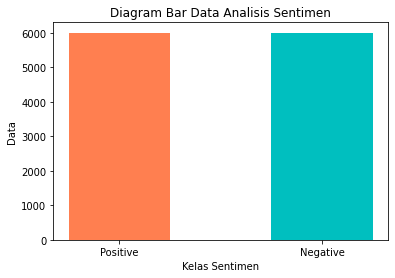

In [ ]:
#diagram batang data awal
labels = ['Positive','Negative']
positif = df2['score'].value_counts()[1]
negatif = df2['score'].value_counts()[0]
data_count = [positif, negatif]
plt.bar(labels, data_count, tick_label=labels, width=0.5, color=['coral', 'c'])
plt.xlabel('Kelas Sentimen')
plt.ylabel('Data')
plt.title('Diagram Bar Data Analisis Sentimen')
plt.show()

In [ ]:
df2.to_csv('fix_and_labelled.csv', index=False)

###Vectorize

In [6]:
data = pd.read_csv('/content/fix_and_labelled.csv')
data = data.dropna()

In [7]:
tf = TfidfVectorizer()
text_tf = tf.fit_transform(data['content'].astype('U'))

In [ ]:
print(text_tf)

  (0, 443)	0.15094757938687176
  (0, 7728)	0.1029752848831837
  (0, 1437)	0.1523037785486411
  (0, 7368)	0.17572387491442595
  (0, 4735)	0.17319201543744409
  (0, 291)	0.26239185005951027
  (0, 6881)	0.27540401099878487
  (0, 6878)	0.27540401099878487
  (0, 5442)	0.2976484470493573
  (0, 1334)	0.37489028808195013
  (0, 1228)	0.5409140340084687
  (0, 7483)	0.31271801789703085
  (0, 6474)	0.20610197726887217
  (1, 6248)	0.3320992638407411
  (1, 1713)	0.23902777659302948
  (1, 7597)	0.2874763462341069
  (1, 3161)	0.26326897129381743
  (1, 2836)	0.26583514222656124
  (1, 2893)	0.21675652555596972
  (1, 1022)	0.22523092092131872
  (1, 3139)	0.2641064758106026
  (1, 4080)	0.23192772168933165
  (1, 3790)	0.3087293934172368
  (1, 1300)	0.14698976432323163
  (1, 7061)	0.3767221814473754
  :	:
  (11758, 3683)	0.47903747415047937
  (11758, 4278)	0.28526157306798394
  (11758, 2757)	0.37575534629869095
  (11758, 4739)	0.4277353527518462
  (11758, 5131)	0.20308822903832047
  (11759, 5220)	1.0
  (117

###Testing #1

In [28]:
x_train, x_test, y_train, y_test = train_test_split(text_tf, data['score'], test_size=0.1, random_state=5)

In [29]:
modelSVM=SVC(kernel='linear', probability=True)
modelSVM.fit(x_train,y_train)
predictedSVM = modelSVM.predict(x_test)

SVM Accuracy :  0.8582342954159593
confusion_matrix : 
 [[536  76]
 [ 91 475]]



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


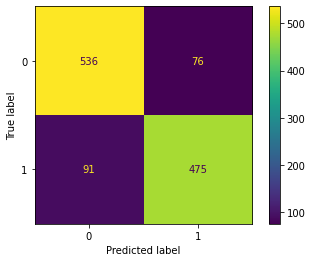

In [30]:
print('SVM Accuracy : ', accuracy_score(y_test,predictedSVM))

print(f'confusion_matrix : \n {confusion_matrix(y_test,predictedSVM)}')
print('=========================================================\n')
plot_confusion_matrix(modelSVM, x_test, y_test)  
plt.show()

###Testing #2

In [31]:
x_train, x_test, y_train, y_test = train_test_split(text_tf, data['score'], test_size=0.3, random_state=5)

In [32]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(8239, 7759)
(8239,)
(3532, 7759)
(3532,)


In [33]:
modelSVM=SVC(kernel='linear', probability=True)
modelSVM.fit(x_train,y_train)
predictedSVM = modelSVM.predict(x_test)

SVM Accuracy :  0.8522083805209513
confusion_matrix : 
 [[1555  258]
 [ 264 1455]]



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


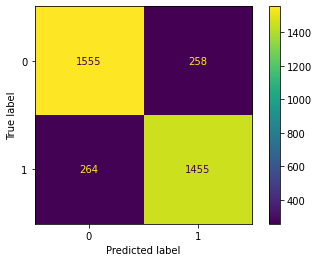

In [34]:
print('SVM Accuracy : ', accuracy_score(y_test,predictedSVM))

print(f'confusion_matrix : \n {confusion_matrix(y_test,predictedSVM)}')
print('=========================================================\n')
plot_confusion_matrix(modelSVM, x_test, y_test)  
plt.show()

###Testing #3

In [35]:
x_train, x_test, y_train, y_test = train_test_split(text_tf, data['score'], test_size=0.5, random_state=5)

In [36]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5885, 7759)
(5885,)
(5886, 7759)
(5886,)


In [37]:
modelSVM=SVC(kernel='linear', probability=True)
modelSVM.fit(x_train,y_train)
predictedSVM = modelSVM.predict(x_test)

SVM Accuracy :  0.834522595990486
confusion_matrix : 
 [[2540  481]
 [ 493 2372]]



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


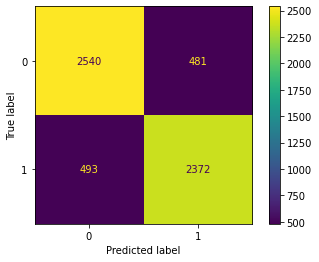

In [38]:
print('SVM Accuracy : ', accuracy_score(y_test,predictedSVM))

print(f'confusion_matrix : \n {confusion_matrix(y_test,predictedSVM)}')
print('=========================================================\n')
plot_confusion_matrix(modelSVM, x_test, y_test)  
plt.show()

###Testing #4

In [39]:
x_train, x_test, y_train, y_test = train_test_split(text_tf, data['score'], test_size=0.1, random_state=10)

In [40]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10593, 7759)
(10593,)
(1178, 7759)
(1178,)


In [41]:
modelSVM=SVC(kernel='linear', probability=True)
modelSVM.fit(x_train,y_train)
predictedSVM = modelSVM.predict(x_test)

SVM Accuracy :  0.8565365025466893
confusion_matrix : 
 [[540  72]
 [ 97 469]]



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


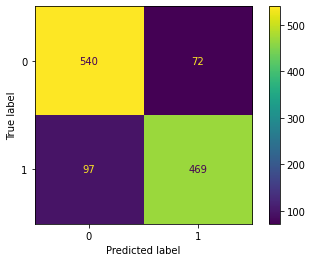

In [42]:
print('SVM Accuracy : ', accuracy_score(y_test,predictedSVM))

print(f'confusion_matrix : \n {confusion_matrix(y_test,predictedSVM)}')
print('=========================================================\n')
plot_confusion_matrix(modelSVM, x_test, y_test)  
plt.show()

###Testing #5

In [43]:
x_train, x_test, y_train, y_test = train_test_split(text_tf, data['score'], test_size=0.3, random_state=10)

In [44]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(8239, 7759)
(8239,)
(3532, 7759)
(3532,)


In [45]:
modelSVM=SVC(kernel='linear', probability=True)
modelSVM.fit(x_train,y_train)
predictedSVM = modelSVM.predict(x_test)

SVM Accuracy :  0.8527746319365799
confusion_matrix : 
 [[1578  232]
 [ 288 1434]]



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


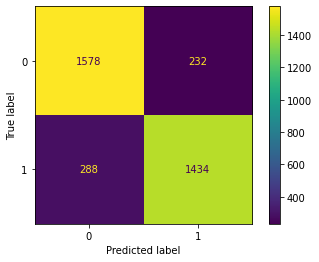

In [46]:
print('SVM Accuracy : ', accuracy_score(y_test,predictedSVM))

print(f'confusion_matrix : \n {confusion_matrix(y_test,predictedSVM)}')
print('=========================================================\n')
plot_confusion_matrix(modelSVM, x_test, y_test)  
plt.show()

###Testing #6

In [47]:
x_train, x_test, y_train, y_test = train_test_split(text_tf, data['score'], test_size=0.5, random_state=10)

In [48]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5885, 7759)
(5885,)
(5886, 7759)
(5886,)


In [49]:
modelSVM=SVC(kernel='linear', probability=True)
modelSVM.fit(x_train,y_train)
predictedSVM = modelSVM.predict(x_test)

SVM Accuracy :  0.8409785932721713
confusion_matrix : 
 [[2555  415]
 [ 521 2395]]



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


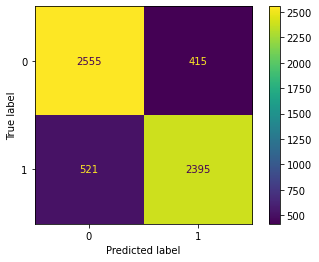

In [50]:
print('SVM Accuracy : ', accuracy_score(y_test,predictedSVM))

print(f'confusion_matrix : \n {confusion_matrix(y_test,predictedSVM)}')
print('=========================================================\n')
plot_confusion_matrix(modelSVM, x_test, y_test)  
plt.show()